### Binary classification based on 3 layers neural network
#### author: Kim Jeong Min

##### load images

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl


transform = transforms.Compose([#transforms.Resize((256,256)),  
                                transforms.Grayscale(),		# the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
                                transforms.ToTensor(),])


#train_data_path = 'relative path of training data set'
train_data_path = 'horse-or-human/train'
trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
# if shuffle=True, the data reshuffled at every epoch 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False, num_workers=1)  


validation_data_path = 'horse-or-human/validation'
valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
valloader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False, num_workers=1)  

IMAGE_VECTOR_SIZE = 10000

train_data = np.empty((IMAGE_VECTOR_SIZE,0))
train_label = np.empty((0,1))
validation_data = np.empty((IMAGE_VECTOR_SIZE,0))
validation_label = np.empty((0,1))

# load training images of the batch size for every iteration
for i, data in enumerate(trainloader):
    # inputs is the image
    # labels is the class of the image
    inputs, labels = data
    # if you don't change the image size, it will be [batch_size, 1, 100, 100]
    train_data = np.hstack((train_data, np.reshape(inputs, (10000,1))))
    # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]
    # human: 1, horse: 0
    train_label = np.append(train_label, 1 if sum(labels)>0 else 0)  

# load validation images of the batch size for every iteration
for i, data in enumerate(valloader):
    # inputs is the image
    # labels is the class of the image
    inputs, labels = data
    # if you don't change the image size, it will be [batch_size, 1, 100, 100]
    validation_data = np.hstack((validation_data, np.reshape(inputs, (10000,1))))
    # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]
    # human: 1, horse: 0
    validation_label = np.append(validation_label, 1 if sum(labels)>0 else 0)

##### add a row(np.ones) in data matrix

In [2]:
train_data_num = len(train_data[0])
validation_data_num = len(validation_data[0])
train_offset_ones = np.ones((1,train_data_num))
validation_offset_ones = np.ones((1,validation_data_num))

train_set = np.insert(train_data, IMAGE_VECTOR_SIZE, train_offset_ones, 0)
validation_set = np.insert(validation_data, IMAGE_VECTOR_SIZE, validation_offset_ones, 0)

##### functions

In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_backward(da, z):
    sig = sigmoid(z)
    return da * sig * (1 - sig)

def get_acc(discri, label):
    prediction = np.round(discri)
    equality = np.equal(prediction, label)
    return sum(equality[0]) / len(equality[0])

def get_loss(discri, label):
    return np.average(-label*np.log(discri) - (1-label)*np.log(np.ones(discri.shape)-discri))

def add_offset_row(matrix):
    return np.insert(matrix, len(matrix), np.ones((1,len(matrix[0]))), 0)

##### neural network structure

In [4]:
INPUT_DIM = IMAGE_VECTOR_SIZE
SECOND_DIM = 20
THIRD_DIM = 5
OUTPUT_DIM = 1

# add 1 offset dimension to input
nn_struct = [
    {'in_dim': INPUT_DIM + 1, 'out_dim': SECOND_DIM},
    {'in_dim': SECOND_DIM + 1, 'out_dim': THIRD_DIM},
    {'in_dim': THIRD_DIM + 1, 'out_dim': OUTPUT_DIM}
]

##### gradient descent on vectorization

In [5]:
nn_struct[0]['W'] = np.random.rand(INPUT_DIM + 1, SECOND_DIM)
nn_struct[1]['W'] = np.random.rand(SECOND_DIM + 1, THIRD_DIM)
nn_struct[2]['W'] = np.random.rand(THIRD_DIM + 1, OUTPUT_DIM)
N = train_data_num

MAX_ITER = 2000
LR = 0.00002

train_acc = list()
validation_acc = list()
train_loss = list()
validation_loss = list()

prev_loss = 0

for iter_num in range(0, MAX_ITER):
    # forward propagation
    discri = train_data
    validation_discri = validation_data
    P = list()
    for layer in nn_struct:
        P.append(discri)
        discri = add_offset_row(discri)
        validation_discri = add_offset_row(validation_discri)
        discri = sigmoid(np.dot(np.transpose(layer['W']), discri))
        validation_discri = sigmoid(np.dot(np.transpose(layer['W']), validation_discri))
    
    # back propagation
    y = train_label
    yhat = discri
    
    w2_ = nn_struct[2]['W'][:-1, :]
    w1_ = nn_struct[1]['W'][:-1, :]
    p2_ = add_offset_row(P[2])
    p1_ = add_offset_row(P[1])
    p0_ = add_offset_row(P[0])    
    
    y_ = -y * (1-yhat) + yhat *(1-y)
    dw2 = np.dot(y_, p2_.T)
    q_ = np.dot(w2_, y_) * P[2] * (1-P[2])
    dw1 = np.dot(q_, p1_.T)
    p_ = np.dot(w1_, q_) * P[1] * (1-P[1])
    dw0 = np.dot(p_, p0_.T)
    
    nn_struct[0]['W'] = nn_struct[0]['W'] - LR * dw0.T
    nn_struct[1]['W'] = nn_struct[1]['W'] - LR * dw1.T
    nn_struct[2]['W'] = nn_struct[2]['W'] - LR * dw2.T
    
    # get accuracy, loss
    train_acc.append(get_acc(discri, train_label))
    loss = get_loss(discri, train_label)
    train_loss.append(loss)
    validation_acc.append(get_acc(validation_discri, validation_label))
    validation_loss.append(get_loss(validation_discri, validation_label))
    
    #check end conditon
    if abs(prev_loss - loss) < 0.000001:
        break
    prev_loss = loss

##### plot Accuracy, Loss

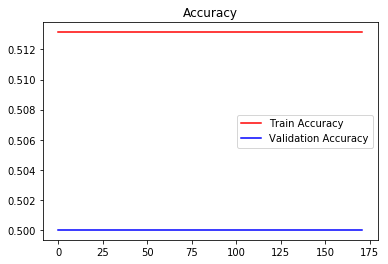

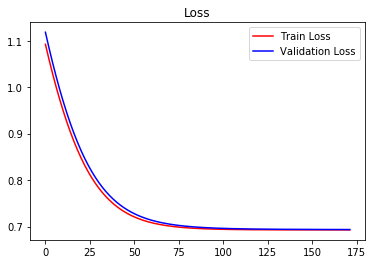

In [6]:
plt.plot(train_acc, color='#ff0000', label='Train Accuracy')
plt.plot(validation_acc, color='#0000ff', label='Validation Accuracy')
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.title('Accuracy')
plt.show()

plt.plot(train_loss, color='#ff0000', label='Train Accuracy')
plt.plot(validation_loss, color='#0000ff', label='Validation Accuracy')
plt.legend(['Train Loss','Validation Loss'])
plt.title('Loss')
plt.show()

##### plot result table

[]

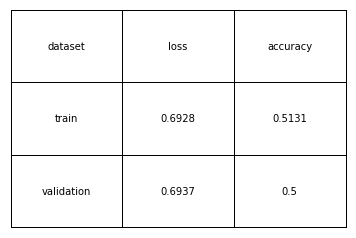

In [7]:
nx, ny = 3, 3
data = (('dataset', 'loss', 'accuracy'), ('train', str(round(train_loss[-1],4)), str(round(train_acc[-1],4))), ('validation', str(round(validation_loss[-1],4)), str(round(validation_acc[-1],4))))
pl.figure()
tb = pl.table(cellText=data, loc=(0,0), cellLoc='center')

tc = tb.properties()['child_artists']
for cell in tc: 
    cell.set_height(1/ny)
    cell.set_width(1/nx)

ax = pl.gca()
ax.set_xticks([])
ax.set_yticks([])